In [1]:
from sklearn.dummy import DummyClassifier
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from typing import Type
from torch.optim import lr_scheduler
from torch.nn import Module,Linear,Sequential,ReLU,ELU,Dropout,BatchNorm1d,Flatten,CrossEntropyLoss,Conv2d,MaxPool2d
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
import sys
import random
import copy
import time
import shutil
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from pandas import DataFrame
import seaborn as sn
import numpy as np
import PIL
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from ipynb.fs.full._3_prepare_tracked_datasets import Char,Poly,Point
from ipynb.fs.full._2_emnist_analyze import LeNet,MyResNet,BasicBlock,Trainer

0
None
0
None
0


/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/lib64/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
BATCH_SIZE=50
EPOCHS=10
ACTIVATE="hardswish"
DROPOUT=True
BATCHNORM=True
TRACK_MAX_LEN=3000
CURRENT_FOLDER="./"
DATASET_VARIANT="byclass"
tr=Trainer()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

class CustomPickler(pickle.Pickler):
    def find_class(self, module, name):
       if name == 'Char' and __name__ != "__main__":
            from Prepare_Dataset import Char
            return Char
       if name == 'Poly' and __name__ != "__main__":
            from Prepare_Dataset import Poly
            return Poly
       if name == 'Point' and __name__ != "__main__":
            from Prepare_Dataset import Point
            return Point
       return super().find_class(module, name)

load dataset

In [6]:
f_train_dict= open(os.path.join(CURRENT_FOLDER,'train_dict_UJI.p'), 'rb')
f_test_dict= open(os.path.join(CURRENT_FOLDER,'test_dict_UJI.p'), 'rb')
TRAIN_DICT = CustomUnpickler(f_train_dict).load()
TEST_DICT = CustomUnpickler(f_test_dict).load()
f_train_dict.close()
f_test_dict.close()

In [7]:
# print(TRAIN_DICT)
# print(TEST_DICT)
CHAR_LIST=list(TRAIN_DICT.keys())
CHAR_LIST.sort()
print("Классов: {}".format(len(list(TRAIN_DICT.keys()))))
print(list(TRAIN_DICT.keys()).sort())
all_size=0
for key in TRAIN_DICT.keys():
  all_size+=len(TRAIN_DICT[key])

Классов: 62
None


In [8]:
all_size

5913

Text(0, 0.5, 'количество образцов')

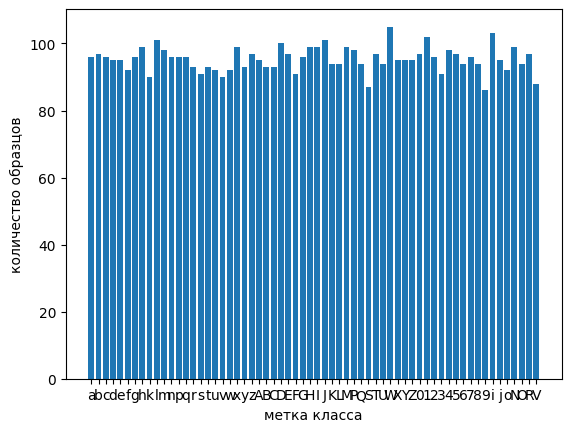

In [9]:
plt.bar( TRAIN_DICT.keys(),[len(TRAIN_DICT[key]) for key in TRAIN_DICT.keys()])
plt.xlabel("метка класса")
plt.ylabel("количество образцов")
# plt.savefig("images/uji_dataset.png",  bbox_inches='tight', pad_inches=0)

Single track length max:6705.0; min:244.0; avg:1566.2812447150347
Single track length>3000: 128


(array([5.670e+02, 2.630e+03, 1.888e+03, 6.430e+02, 1.280e+02, 3.500e+01,
        1.300e+01, 5.000e+00, 2.000e+00, 2.000e+00]),
 array([ 244. ,  890.1, 1536.2, 2182.3, 2828.4, 3474.5, 4120.6, 4766.7,
        5412.8, 6058.9, 6705. ]),
 <BarContainer object of 10 artists>)

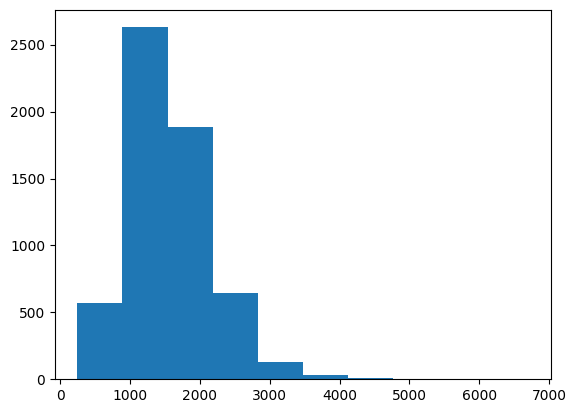

In [10]:
data=TRAIN_DICT
rez=np.array([])
for key in data.keys():
    for ch in data[key]:
        rez=np.append(rez,len(ch.singlePolys().angles))
print("Single track length max:{}; min:{}; avg:{}".format(max(rez),min(rez),sum(rez)/len(rez)))  
print("Single track length>{}: {}".format(TRACK_MAX_LEN,sum(rez>TRACK_MAX_LEN)))
plt.hist(rez)

1553


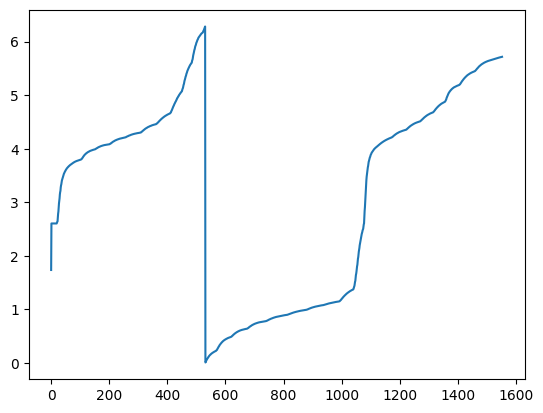

In [11]:
data=TRAIN_DICT['a'][0].singlePolys().angles
print(len(data))
plt.plot(range(len(data)),data)

In [12]:
class DynDataset(Dataset):

    def __init__(self, data, transform=None, data_type='fft_angles',track_max_len=TRACK_MAX_LEN):
        str="0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
        self.type=data_type
        self.track_max_len=track_max_len
        self.data=np.array([])
        for key in data.keys():
            for ch in data[key]:
                if key in str:
                    self.data=np.append(self.data,[ch])              
        self.classes=list(str)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_ix = np.zeros([self.track_max_len], dtype='float32')
        if self.type=='angles':
            vec=self.data[idx].singlePolys().angles
        elif self.type=='speed':
            vec=self.data[idx].singlePolys().speeds
        elif self.type=='fft_angles':
            vec=self.data[idx].singlePolys().fft_angles
        else:
            vec=self.data[idx].singlePolys().fft_speeds  
        # ограничим длинну трека
        data_ix[:len(vec)] = vec[:self.track_max_len]
        class_num=self.classes.index(self.data[idx].name)
        return torch.Tensor(data_ix),class_num

In [13]:
vec_datasets = {"train": DynDataset(TRAIN_DICT, data_type='angles'),
                 "val":DynDataset(TEST_DICT, data_type='angles')}
dataloaders = {"train": torch.utils.data.DataLoader(vec_datasets["train"], batch_size=BATCH_SIZE,shuffle=True),
               "val": torch.utils.data.DataLoader(vec_datasets["val"], batch_size=BATCH_SIZE,shuffle=True),
}
dataset_sizes = {x: len(vec_datasets[x]) for x in ['train', 'val']}
classes_names = {x: vec_datasets[x].classes for x in ['train', 'val']}

torch.Size([3, 50, 3000])


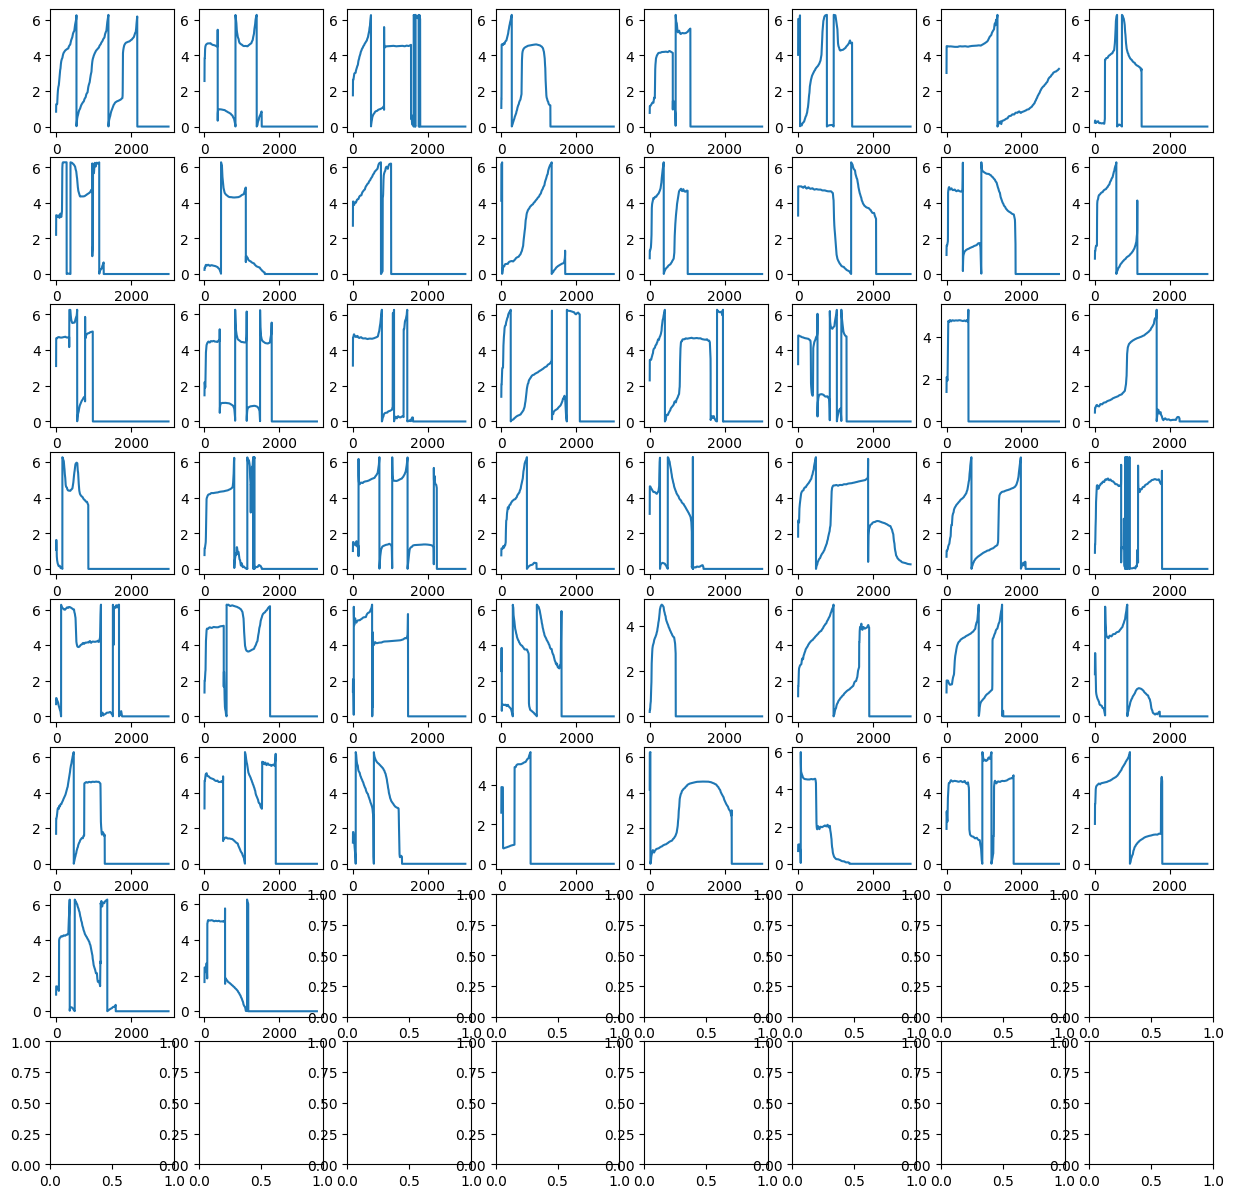

    a     n     q     y     x     9     b     5     7     7     t     e     4     b     D     U     M     m     E     5     q     M     I     t     3     F     W     c     5     y     d     H     z     R     Y     3     s     Q     a     v     9     R     3     x     f     T     H     U     5     r


In [14]:
from math import sqrt

def imshow(img):
    n=int(sqrt(BATCH_SIZE))+1
    npimg = img.numpy()
    img=npimg[0]
    figure, axis = plt.subplots(n, n,figsize=(15, 15))
    count=0
    for j in range(n):
        for i in range(n):
            if count<img.shape[0]:
                axis[j, i].plot(range(TRACK_MAX_LEN),img[count])
            count+=1
    plt.savefig("images/uji_images_angles.png",  bbox_inches='tight', pad_inches=0)      
    plt.show()
    
# Get a batch of training data
image, label = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(image)
print(out.shape)
imshow(torchvision.utils.make_grid(out))
str=' '.join('%5s' % vec_datasets['val'].classes[label[j]] for j in range(BATCH_SIZE))
print(str)
with open('images/uji_angles_lbl.txt', 'w') as f:
    f.write(str)

create model

FCNN

In [15]:
class FNNCell(torch.nn.Module):
    def __init__(self,channel=1,track_max_len=TRACK_MAX_LEN,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(FNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(track_max_len, 256))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Linear(256, 100))
        l.append(Trainer.getActivateFunction(activate))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=1))

       
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(100,num_classes)
        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        # x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        return x    

In [16]:
net=FNNCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

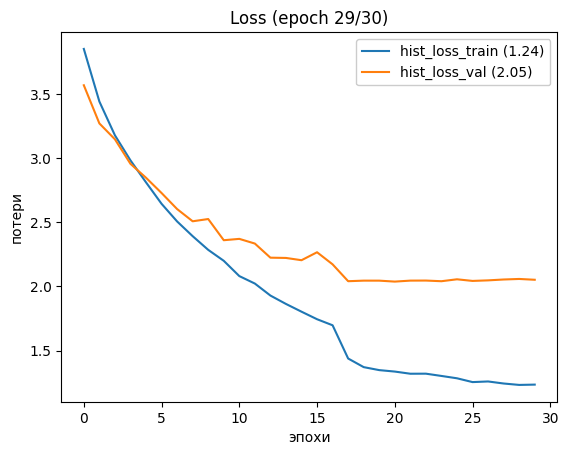

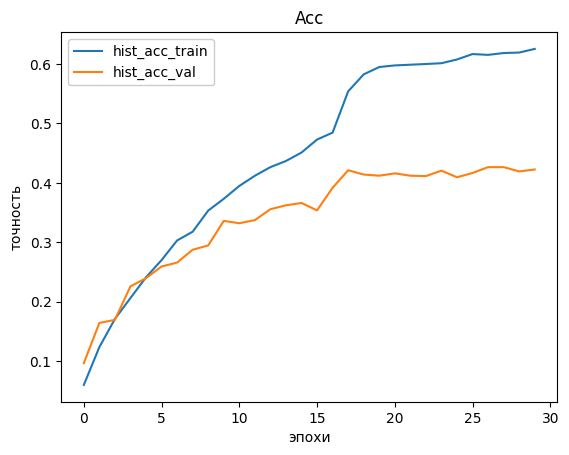

Train time:49.55186605453491
Best acc:0.41584806810740016


In [18]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="FNNCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

RNN2

In [20]:
class RNN2Cell(nn.Module):

    def __init__(self, track_max_len=TRACK_MAX_LEN,num_classes=len(CHAR_LIST),  rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 1
        self.rnn = nn.RNN(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          dropout=0.2
                         )
        self.rnn_to_logits = nn.Linear(self.num_units, num_classes)

    def forward(self, x):
        # x = torch.transpose(x,0,1)
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output)
        return logits[:,self.track_max_len-1] # только последний элемент в цепочке


In [21]:
# x=torch.Tensor([[1,2,3,4],[10,20,30,40]])
# # x=torch.transpose(x,0,1)
# x=x[:,:,None]
# x

In [22]:
net=RNN2Cell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

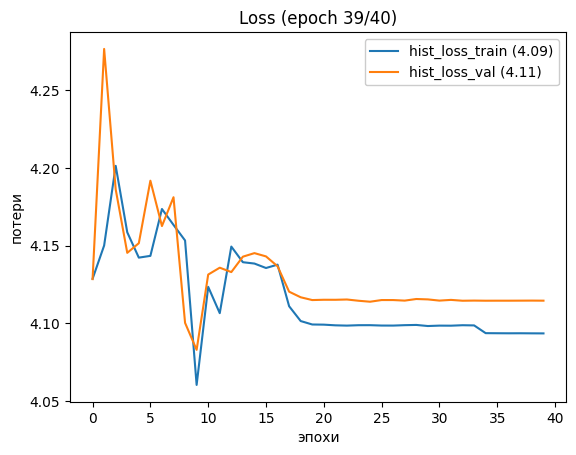

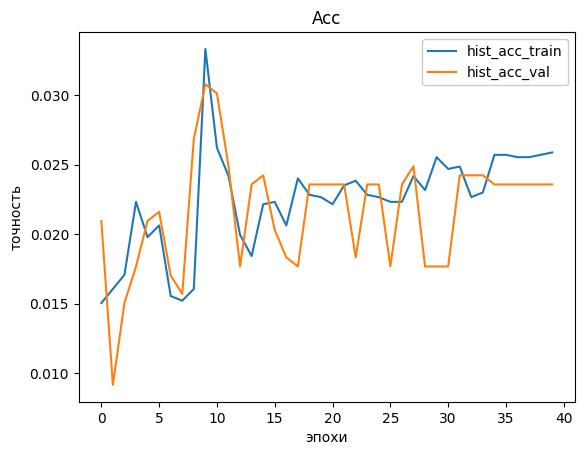

Train time:267.8344678878784
Best acc:0.030779305828421744


In [24]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="RNN2Cell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

LSTM

In [15]:
class LSTMCell(nn.Module):

    def __init__(self, track_max_len=TRACK_MAX_LEN,num_classes=len(CHAR_LIST),  rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.track_max_len=track_max_len
        self.num_units = rnn_num_units
        self.num_layers = 1
        self.rnn = nn.LSTM(1,
                          self.num_units,
                          num_layers=self.num_layers,
                          batch_first=True,
                          # dropout=0.2
                          )
        self.rnn_to_logits = nn.Linear(self.num_units, num_classes)

    def forward(self, x):
        x=x[:,:,None]
        output, _ = self.rnn(x)
        logits = self.rnn_to_logits(output)
        return logits[:,self.track_max_len-1] # только последний элемент в цепочке

In [16]:
net=LSTMCell(track_max_len=TRACK_MAX_LEN,num_classes=len(vec_datasets["train"].classes)).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

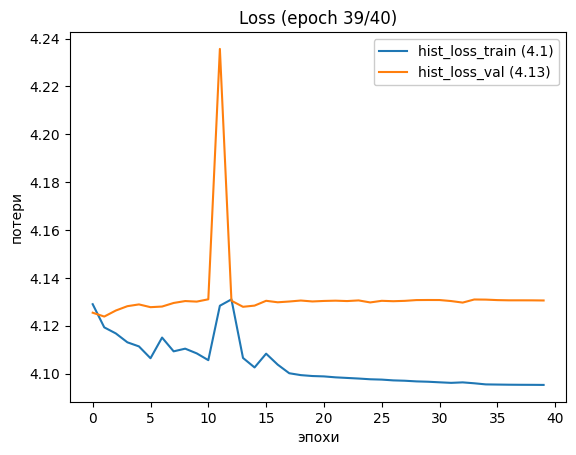

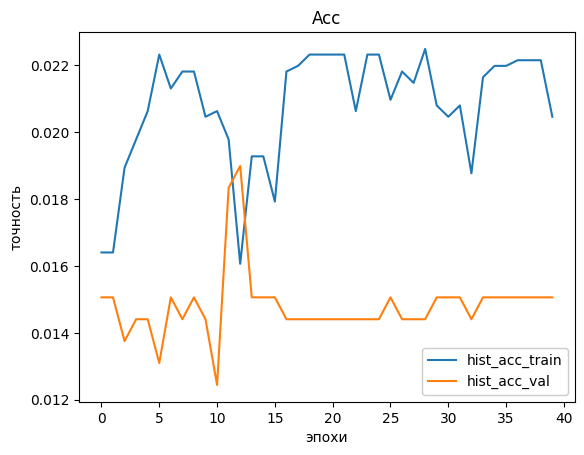

Train time:1142.311011314392
Best acc:0.015062213490504257


In [18]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=40, net_name="LSTMCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

CNN

In [ ]:
class CNNCell(torch.nn.Module):
    def __init__(self,channel=1,num_classes=len(CHAR_LIST),activate=ACTIVATE):
        super(CNNCell, self).__init__()
        self.SHOW=0
        self.layers=torch.nn.ModuleList()  

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(1, 20, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=20))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(20, 30, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(2))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=30))

        l=torch.nn.ModuleList()
        self.layers.append(l)
        l.append(torch.nn.Conv1d(30, 40, 3))
        l.append(Trainer.getActivateFunction(activate))
        l.append(torch.nn.MaxPool1d(7))
        if DROPOUT: l.append(torch.nn.Dropout(0.05))
        if BATCHNORM: l.append(torch.nn.BatchNorm1d(num_features=40))

        self.ga = torch.nn.AdaptiveMaxPool1d(7)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(7*40,num_classes)

        
    def forward(self, x):
        x = self._forward(x)      
        x = self.fc1(x)
        return x

    def _forward(self, x):
        n=1 
        x =  x[:,None,:]

        for layer in self.layers:
          for elem in layer:
            x=elem(x)
            if self.SHOW==0: print("--->   {}".format(x.shape))   
          n+=1 
          if self.SHOW==0: print("====")  
        self.SHOW+=1
        x = self.ga(x)
        x = self.flat(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        #x = self.sm(x)
        return x
    
    def _inference(self, x):
        x = self._forward(x)
        #x = self.sm(x)
        return x

In [ ]:
net=CNNCell(num_classes=len(vec_datasets["train"].classes)).to(device)

train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=17, gamma=0.1)

In [ ]:
if __name__ == "__main__":
    start = time.time()
    model,acc=tr.train_model(net, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=30, net_name="CNNCell_uji")
    end = time.time()
    print("Train time:{}".format(end - start))
    print("Best acc:{}".format(acc))

transfer learning

analyze

In [113]:
_preds=np.array([])
_targets=np.array([])
for inputs, labels in dataloaders['val']:    # Iterate over data.
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    _targets=np.append(_targets, labels.detach().cpu().numpy())
    _preds=np.append(_preds,preds.detach().cpu().numpy())


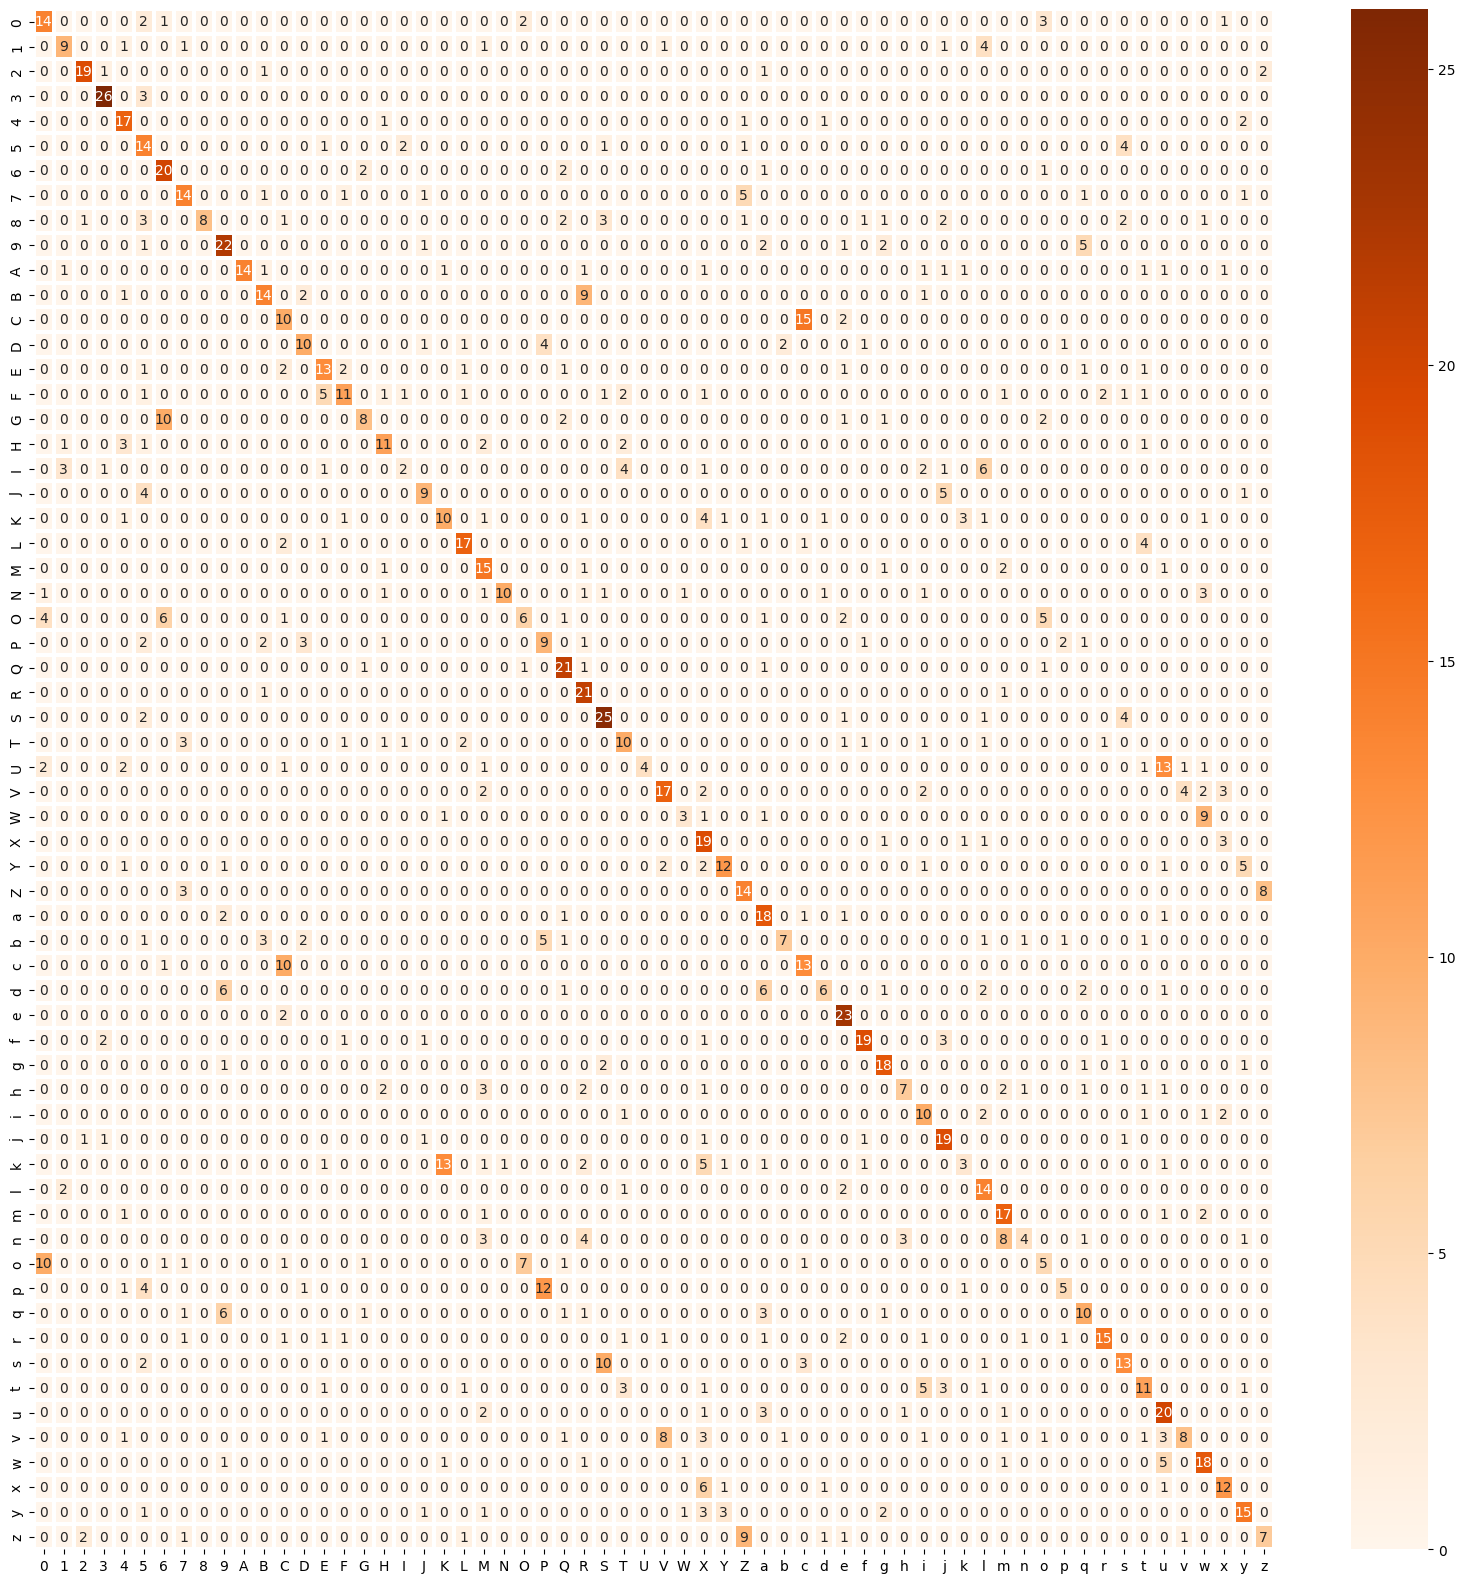

In [115]:
cm=metrics.confusion_matrix(_targets,_preds)
df_cm = DataFrame(cm, index=classes_names["val"], columns=classes_names["val"])
from pandas import DataFrame
import seaborn as sn
plt.subplots(figsize=(20,20))
sn.heatmap(df_cm,annot=True, fmt="d",linewidths=1.5,cmap="Oranges",)
plt.savefig("images/CNNCell_uji_confusion_matrix.png",  bbox_inches='tight', pad_inches=0)
plt.show()